# Homework 2 - Timeseries
## Data Analysis
### FINM August Review 

Mark Hendricks

hendricks@uchicago.edu

# Data
* This homework uses the file, `data/ols_forecasting_inflation_data.xlsx`.
* Find the data in the Github repo associated with the module, (link on Canvas.)

The data file contains...
* Macroeconomic Data
    - Core CPI price index, denoted as $p$. 
    - M2 Money Supply, denoted as $m$.
* Financial data
    - Returns on the S&P 500, (via the SPY ETF)
* See the “build data” folder for the details on how the data was constructed

$$\newcommand{\spy}{\text{spy}}$$
$$\newcommand{\hyg}{\text{hyg}}$$

In [21]:
# PACKAGES
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import matplotlib.pyplot as plt
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               StrMethodFormatter,
                               AutoMinorLocator)

# 1. Assessing the OLS Model

This problem considers the predictability of inflation over various horizons. To do so, note the following:
* $i_{t,t+h}$: Inflation is the h-period growth rate of CPI: 

$$i_{t,t+h} ≡ \frac{p_{t+h}}{p_t} − 1$$

* $g_{t,t+h}$: Money growth considered below is the growth rate of M2 Money supply:

$$g_{t,t+h} ≡ \frac{m_{t+h}}{m_t} − 1$$

In [22]:
# Read the data
macro = pd.DataFrame(pd.read_excel(r'../data/ols_forecasting_inflation_data.xlsx', sheet_name= 'macro'))
macro.set_index('date', inplace=True)

sp500 = pd.DataFrame(pd.read_excel(r'../data/ols_forecasting_inflation_data.xlsx', sheet_name= 1))
sp500.set_index('Date', inplace= True)


In [23]:
prices = macro['CPI']
money = macro['M2']

FREQ = 12

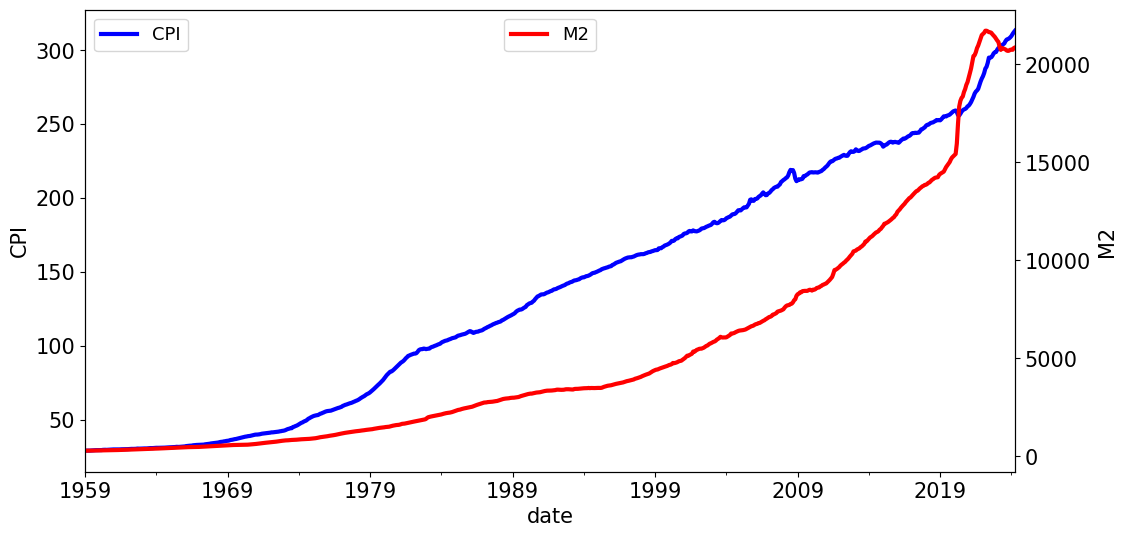

In [24]:
ax = macro[['CPI']].plot(color='b',linewidth=3,ylabel='CPI',legend=['CPI'])
ax2 = plt.twinx(ax)
macro[['M2']].plot(ax=ax2,color='r',linewidth=3,ylabel='M2',legend=['M2'])
plt.legend(loc='upper center')
plt.show()

## 1. 

Estimate an OLS regression to see if CPI and Money are contemporaneously correlated: 

$$p_t = \alpha + \beta m_t + \epsilon_t$$

* Note that this is not a lagged regression, but rather a contemporaneous time-series regression. (We are not predicting a period ahead but rather fitting one series to the other at the same time period.)

- (a) Report the estimated R-squared. 
- (b) Report the point-estimate of $\beta$.


In [25]:
ols = sm.OLS(macro[['CPI']], sm.add_constant(macro[['M2']])).fit()
print(ols.summary())


                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     3953.
Date:                Wed, 21 Aug 2024   Prob (F-statistic):          4.74e-308
Time:                        08:58:30   Log-Likelihood:                -3862.5
No. Observations:                 784   AIC:                             7729.
Df Residuals:                     782   BIC:                             7738.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.1015      1.643     40.233      0.0

## 2. 

This time, examine a regression of growth rates. Specifically, estimate an OLS regression to see if inflation and money growth are contemporaneously correlated:

$$i_{t,t+h} = \alpha + \beta g_{t,t+h} + \epsilon_{t,t+h}$$

* Note that this is not a lagged regression, but rather a regular time-series regression.

Answer the questions below for a one-year horizon: $h = 12$. 
- (a) Report the estimated R-squared.
- (b) Report the point-estimate of $\beta$.



In [26]:
# Calculate growth rates
macro['grate_cpi'] = macro['CPI'].pct_change(12)
macro['grate_m2'] = macro['M2'].pct_change(12)

# Regression ignoring NAs
ols_grate = sm.OLS(macro[['grate_cpi']], sm.add_constant(macro[['grate_m2']]), missing = 'drop').fit()
print(ols_grate.summary())


                            OLS Regression Results                            
Dep. Variable:              grate_cpi   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.293
Date:                Wed, 21 Aug 2024   Prob (F-statistic):             0.0700
Time:                        08:58:31   Log-Likelihood:                 1661.7
No. Observations:                 772   AIC:                            -3319.
Df Residuals:                     770   BIC:                            -3310.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0344      0.002     16.377      0.0


## 3. 

The result of regressing inflation on money growth is very different from regressing CPI on Money. 

- (a) What do you conclude? 
- (b) Does it seem that variation in money contemporaneously explains variation in inflation?
- (c) In particular, what is wrong with one of the two regression models? Consider plotting the raw dependent and independent variable of each.



### Answer

(a) There is a positive correlation between the price index levels and money level, but this relationship doesn't exist when we do the regression on inflation and money growth. 


(b) According to the regression, it doesn't seem to be a variation in contemporary inflation associated with variation in money growth.


(c) The series in levels are not stationary time series and the correlation might be spurious. We need to use I(0) time series. 


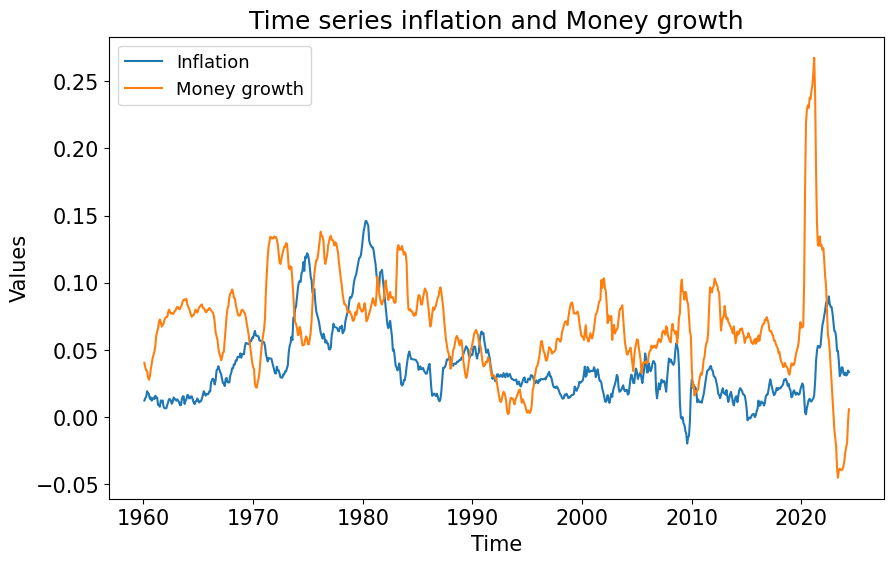

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(macro[['grate_cpi']], label='Inflation')
plt.plot(macro[['grate_m2']], label='Money growth')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Time series inflation and Money growth')
plt.legend()
plt.show()



## 4.

Answer the remaining questions regarding the estimation of inflation on money growth in 1.2 above.

Do the sample residuals, $e$ seem to be iid? That is,
- (a) do they seem to be drawn from a constant variance? 
- (b) do they have serial correlation?

Assess this informally by plotting the time-series of estimated sample residuals, $e$.

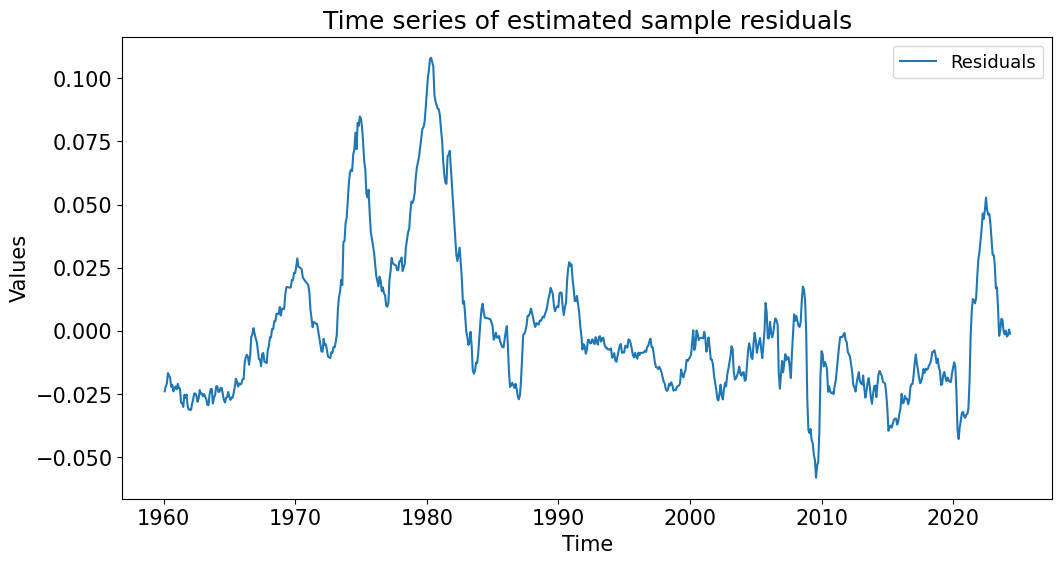

In [28]:
residuals = ols_grate.resid

plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Time series of estimated sample residuals')
plt.legend()
plt.show()

### Answer

The residuals do not seem to be draw from a distribution with constant variance
Yes, it apers to have serial correlation because the residuals follow values similar to the previous observation instead of being randomly distributed. 

## 5.


Suppose that the residuals do not fit the classic OLS assumptions. (Technically speaking, consider that they are heteroskedastic and have serial correlation.)

- (a) Report whether the estimates for $\alpha$ or $\beta$ are statistically significant relative to 0, for a significance level of 5%. (Check the reported p-value for each of the estimates, perhaps using stats-models OLS function.)
- (b) Do you have concerns about the accuracy of the reported p-values?
- (c) Do you have concerns about the estimated beta? For small samples, for large samples?


### Answer

(a) The estimates are statistically different from zero in the regression in levels, but not in the regression in the growth rates.


(b) Yes because the standard errors are calculated incorrectly because there is serial correlation in the errors.


(c) For small sample yes because the exogeneity condition is not true. But we are not assuming that this assumption is not assumed to be violated (but most likely it is).
For large samples we are only interested in consistency and we know that the coefficients will converge to the true beta as n tends to infinity. 


## 6. 

- (a) Assess the residuals with the Durbin-Watson test for serial correlation. 
- (b) Formally assess heteroskedasticity of the residuals with White’s test.



In [29]:
print(f"The Durbin-Watson test for serial correlation is {sm.stats.stattools.durbin_watson(residuals)}. Very close to zero meaning that we have positive serial correlation")

white_test = sm.stats.diagnostic.het_white(residuals, sm.add_constant(macro[['grate_m2']]).dropna())

#define labels to use for output of White's test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

#print results of White's test
print(dict(zip(labels, white_test)))


The Durbin-Watson test for serial correlation is 0.019597387785175977. Very close to zero meaning that we have positive serial correlation
{'Test Statistic': 17.63836881825986, 'Test Statistic p-value': 0.0001478689115993215, 'F-Statistic': 8.990320464730807, 'F-Test p-value': 0.00013819767405483217}


### Answer
Based on the results from the Durbin-Watson test, and the White's test for heterokedasticity of the residuals, we can reject the null hypothesis that the errors are randomly distributed, i.e., that the errors are homoscedastic.



### Hints

- (a) This is reported by default in the stats-models OLS estimation summary. A value less than 2 would indicate potential issues with serial correlation.
- (b) See the documentation for the stats-model package.

## 7. 

Try redoing this entire problem, but this time with a lagged, forecasting regression instead of a contemporaneous regression. Namely, replace the equation in 1.2 with,

$$i_{t,t+h} = \alpha + \beta g_{t-h,t} + \epsilon_{t,t+h}$$

What do you think of the ability of past inflation and money growth to forecast future inflation?

### Hint
This should be easy to reform just this equation and then rerun the same code.

***

# 2 Models of Volatility

We will calculate a time-series of volatility estimates using a few different methods. For each, we use $\sigma_t$ to denote our estimate of the time-$t$ return volatility, as based on data over periods through $t-1$, but not including $t$ itself. 

This problem uses data from `data/ols_forecasting_inflation_data.xlsx`.

Estimate the following using the SPY return series. We use a common (but biased) version of the usual variance estimator by ignoring $\mu$ and dividing by the number of data points, rather than by the degrees of freedom. 

### Expanding Series
$$\begin{align*}
\sigma^2_{t} =& \frac{1}{t-1}\sum_{\tau=1}^{t-1} r_\tau ^ 2
\end{align*}$$

Begin the calculation at $t=61$, so that the first estimate is based on 60 data points.



### Rolling Window
\begin{align*}
\sigma^2_{t} =& \frac{1}{m}\sum_{l=1}^{m} r_{t-l}^2
\end{align*}
Use $m=60$, and begin the calculation at the $t=61$, (so that the calculation has a full 60 data points.) Consider using pandas method `df.rolling(60).std()`, where `df` is replaced by the name of your pandas dataframe.

In [30]:
spy = pd.read_excel(r'../data/ols_forecasting_inflation_data.xlsx',sheet_name='s&p500').set_index('Date')
FREQ = 12

In [31]:
### Expanding Window
var = (spy**2).shift(1).expanding().mean().rename(columns={'SPY':'Expanding Window'})

### Rolling Window
var['Rolling Window'] = (spy**2).shift(1).rolling(60).mean() 

### IGARCH 
(famously used in *JP Morgan's Risk Metrics*)
$$\begin{align*}
\sigma^2_{t} =& \theta \sigma^2_{t-1} + (1-\theta) r_{t-1}^2
\end{align*}$$

Rather than estimating $\theta$, simply use $\theta = 0.97$, and initialize with $\sigma_1 = 0.15\left(\frac{1}{\sqrt{12}}\right)$.



In [32]:
# Initial Conditions
var_1 = (0.15 * (1 / (12**0.5)))**2
theta = 0.97

In [33]:
GARCH = arch_model(sp500['SPY'], vol='Garch', p=1, o=0, q=1, dist='Normal')

GARCH_model = GARCH.fit()

GARCH_model.params

Iteration:      1,   Func. Count:      6,   Neg. LLF: 136905287.20325646
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1044759.9548106429
Iteration:      3,   Func. Count:     24,   Neg. LLF: -669.8186331265372
Iteration:      4,   Func. Count:     30,   Neg. LLF: 9212.798170910562
Iteration:      5,   Func. Count:     40,   Neg. LLF: 537.2601220639692
Iteration:      6,   Func. Count:     49,   Neg. LLF: -669.1535312645367
Iteration:      7,   Func. Count:     55,   Neg. LLF: -678.3262292913266
Iteration:      8,   Func. Count:     61,   Neg. LLF: -667.851868240446
Iteration:      9,   Func. Count:     67,   Neg. LLF: -679.1765228203155
Iteration:     10,   Func. Count:     73,   Neg. LLF: -679.1927990554591
Iteration:     11,   Func. Count:     79,   Neg. LLF: -679.2012046619566
Iteration:     12,   Func. Count:     84,   Neg. LLF: -679.2012683140181
Iteration:     13,   Func. Count:     88,   Neg. LLF: -679.2012683139549
Optimization terminated successfully    (Exit mode 0)


/Users/charleston/.pyenv/versions/3.11.0/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


mu          0.010132
omega       0.000097
alpha[1]    0.193990
beta[1]     0.766856
Name: params, dtype: float64


### GARCH(1,1)
$$\begin{align*}
\sigma^2_{t} =& \omega + \theta \sigma^2_{t-1} + \gamma r_{t-1}^2
\end{align*}$$

To estimate GARCH(1,1), try using the ARCH package in Python. The default estimation implementation is fine, (and will account for $\mu$ and degrees of freedom.) 

In [34]:
IGARCH = arch_model(sp500['SPY'])

IGARCH.volatility = EWMAVariance(theta)

IGARCH_model = IGARCH.fit()

IGARCH_model.params

Iteration:      1,   Func. Count:      3,   Neg. LLF: 2569432.4090324664
Iteration:      2,   Func. Count:     10,   Neg. LLF: -653.1424941911657
Optimization terminated successfully    (Exit mode 0)
            Current function value: -653.142494191251
            Iterations: 2
            Function evaluations: 10
            Gradient evaluations: 2


/Users/charleston/.pyenv/versions/3.11.0/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00185. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


mu    0.008827
Name: params, dtype: float64

In [35]:
var[['GARCH','IGARCH']] = None

### Initialize with the given parameter
var.iloc[0,2:] = var_1 

### Simulate the rest of the period using the initial variance given
for i in range(1, len(var)):
    ### Forecast variance by plugging the GARCH and IGARCH parameters into their respective equations
    var['IGARCH'].iloc[i] = var['IGARCH'].iloc[i-1] * theta + (1-theta)*(spy.iloc[i-1,0]**2)
    var['GARCH'].iloc[i] = GARCH_model.params['omega'] + var['GARCH'].iloc[i-1] * GARCH_model.params['beta[1]'] + GARCH_model.params['alpha[1]']*(spy.iloc[i-1,0]**2)
    
var = var.dropna()

var.tail() * FREQ

/var/folders/8m/h9p4w9xx385dnwz_x2453dyc0000gn/T/ipykernel_48734/3416200921.py:9: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  var['IGARCH'].iloc[i] = var['IGARCH'].iloc[i-1] * theta + (1-theta)*(spy.iloc[i-1,0]**2)
/var/folders/8m/h9p4w9xx

,Expanding Window,Rolling Window,GARCH,IGARCH
Date,,,,
2024-01-31,0.023259,0.035861,0.033453,0.031892
2024-02-29,0.023205,0.034629,0.027413,0.031026
2024-03-31,0.023230,0.034964,0.028531,0.031076
2024-04-30,0.023202,0.035112,0.025537,0.030529
2024-05-31,0.023193,0.035104,0.024537,0.030198


For each of these methods, 

## 2.1
Plot $\sigma_t$. (Plot the volatility, the square-root of the variance.)



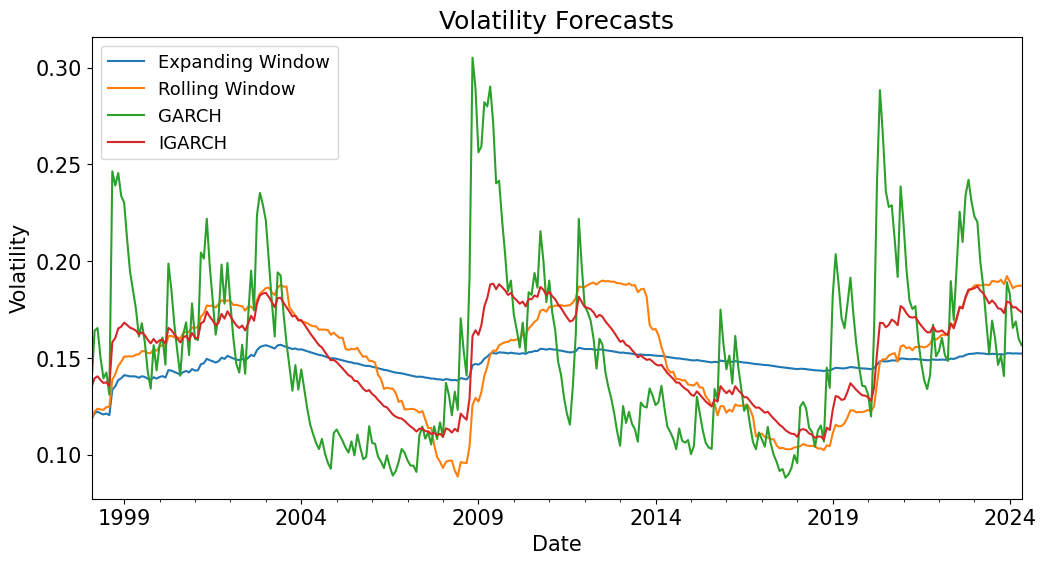

In [36]:
### Convert variance to volatility
vol = (var * FREQ)**.5

vol.plot()
plt.title('Volatility Forecasts')
plt.ylabel('Volatility')

plt.show()



## 2.2
Report the estimation for October 2008, April 2020, and May 2024.

In [37]:
dts = ['2008-11-30','2020-03-31','2024-05-31']
vol.loc[dts]

,Expanding Window,Rolling Window,GARCH,IGARCH
Date,,,,
2008-11-30,0.146284,0.125706,0.305119,0.161393
2020-03-31,0.144813,0.124986,0.163601,0.134557
2024-05-31,0.152291,0.187360,0.156642,0.173776


***